In [2]:
# Dependencies

import os, glob
import sys
sys.path.append("C:\pygplates_0.36.0_py39_win64")
import pygplates
import pybacktrack
import pygmt

from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import csv

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore", "Well thickness .* is larger than the total sediment thickness")
warnings.filterwarnings("ignore", "Dynamic topography model .* cannot")

In [3]:
# Import sedimentary column data

# Rifting beginning 1659 Ma
data59 = r"C:\pybacktrack_examples\test_data\central_lawn_hill_lithology_1659.txt" 

# Rifting beginning 1647 Ma (Omitted Gun 2, Gun 3 and Loretta 1 units)
data47 = r"C:\pybacktrack_examples\test_data\central_lawn_hill_lithology_1647.txt" 

# Code Workflow

In [4]:
# Functions

def misfit(s_o, s_c, var):
    '''
    Calculate RMS misfit values for two curves.
    
        Parameters:
            s_o (one-dimensional array): observed subsidence data
            s_c (one-dimensional array): modelled subsidence data
            var (one-dimensional array): observed subsidence uncertainties
            
        Returns:
            A float for the misfit value
    '''
    term = []
    for i in range(len(s_o)):
        term.append(((s_o[i] - s_c[i]) / var[i]) ** 2)
        
    H = np.sqrt(np.sum(term) / len(s_o)) 
    return H


def model_filter(search_for, search_in, zlab = False, beta = False, riftdur = False):
    '''
    Extract all files and content with the same fixed parameter.
        
        Parameters:
            search_for (int): Value to be searched
            search_in (list): Values to search through
            zlab (bool): If True, search for files with LAB depth value of 'search_for'
            beta (bool): If True, search for files with beta value of 'search_for'
            riftdur (bool): If True, search for files with rift duration value of 'search_for'
            
        Returns:
            An array of lists with three columns. The first two contain the other two parameters,
            and the third is the associated misfit value
    '''
    ls = []
    for i in range(len(all_filename)):
        
        if zlab == True:
            if all_filename[i][-15:-12] == str(search_for):
                ls.append([float(all_filename[i][-11:-7]),
                           float(all_filename[i][-6:-4]),
                           search_in[i]])
                
        elif beta == True:
            if all_filename[i][-11:-7] == "{:.2f}".format(round(search_for, 2)):
                ls.append([float(all_filename[i][-15:-12]),
                           float(all_filename[i][-6:-4]),
                           search_in[i]])
        
        elif riftdur == True:
            if all_filename[i][-6:-4] == str(search_for):
                ls.append([float(all_filename[i][-15:-12]), 
                           float(all_filename[i][-11:-7]),
                           search_in[i]])
    return np.array(ls)


def surface(data, inc):
    '''
    Grid table data using pygmt.surface.
    
        Parameters:
            data (multi-dimensional array): x,y,z values
            inc (str): Grid spacing or increment unit
            
        Returns:
            an xarray.DataArray of gridded data
    '''
    surf = pygmt.surface(x = data[:,0], y = data[:,1], z = data[:,2], 
                         region = [min(data[:,0]), max(data[:,0]), 
                                   min(data[:,1]), max(data[:,1])],
                         spacing = inc)
    return surf
    

In [5]:
# Backstrip to find water-loaded subsidence
well59, decsec59 = pybacktrack.backstrip_well(data59, pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)
well47, decsec47 = pybacktrack.backstrip_well(data47, pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)


# Extract ages, subsidence and subsidence uncertainties
ages59 = [sec.get_age() for sec in decsec59]
tec_sub59 = [sec.get_tectonic_subsidence() for sec in decsec59]
minmax_tect_sub59 = [sec.get_min_max_tectonic_subsidence() for sec in decsec59]
sub_unc59 = [0.5 * (max_tec_sub - min_tec_sub) for max_tec_sub, min_tec_sub in minmax_tect_sub59]

ages47 = [sec.get_age() for sec in decsec47]
tec_sub47 = [sec.get_tectonic_subsidence() for sec in decsec47]
minmax_tect_sub47 = [sec.get_min_max_tectonic_subsidence() for sec in decsec47]
sub_unc47 = [0.5 * (max_tec_sub - min_tec_sub) for max_tec_sub, min_tec_sub in minmax_tect_sub47]

# Identify directly measured and inferred ages
ages_dir59 = []
ages_inf59 = []
sub_dir59 = []
sub_inf59 = []
unc_dir59 = []
unc_inf59 = []

ages_dir47 = []
ages_inf47 = []
sub_dir47 = []
sub_inf47 = []
unc_dir47 = []
unc_inf47 = []

for i in range(len(ages59)):
    if ages59[i] % 1 == 0.5:
        ages_inf59.append(ages59[i])
        sub_inf59.append(tec_sub59[i])
        unc_inf59.append(sub_unc59[i])
    else:
        ages_dir59.append(ages59[i])
        sub_dir59.append(tec_sub59[i])
        unc_dir59.append(sub_unc59[i])
        
for i in range(len(ages47)):
    if ages47[i] % 1 == 0.5:
        ages_inf47.append(ages47[i])
        sub_inf47.append(tec_sub47[i])
        unc_inf47.append(sub_unc47[i])
    else:
        ages_dir47.append(ages47[i])
        sub_dir47.append(tec_sub47[i])
        unc_dir47.append(sub_unc47[i])

In [6]:
# Parameters for misfit calculation

time59 = np.array(ages59) - ages59[0]
sub_obs59 = np.array(tec_sub59[::-1])
var_obs59 = np.array(sub_unc59[::-1])
time47 = np.array(ages47) - ages47[0]
sub_obs47 = np.array(tec_sub47[::-1])
var_obs47 = np.array(sub_unc47[::-1])

In [7]:
# Calculate all misfit values and idenntify global minima

H_min59 = float("inf")
model_min59 = []
file_H59 = ""

H_min47 = float("inf")
model_min47 = []
file_H47 = ""

all_H59 = []
all_H47 = []
all_filename = []

path = r"C:\Users\edgar\OneDrive\Documents\2022\Honours\Data_(Temporal)\sweep_curves"

for filename in glob.glob(os.path.join(path, '*.dat')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        datContent = np.float_([i.strip().split() for i in open(filename).readlines()])
        
        # Sample subsidence value via linear interpolation
        # at the same age points as observed data constraint.
        sub_cal59 = np.interp(time59, datContent[..., 1], datContent[..., 3]) 
        
        minimum = misfit(sub_obs59, sub_cal59, var_obs59) # Misfit calculation
        all_H59.append(minimum) 
        all_filename.append(filename)
        if minimum < H_min59: # Identify minimum misfit value
            H_min59 = minimum
            file_H59 = filename
            model_min59 = datContent
            
for filename in glob.glob(os.path.join(path, '*.dat')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        datContent = np.float_([i.strip().split() for i in open(filename).readlines()])
        
        sub_cal47 = np.interp(time47, datContent[..., 1], datContent[..., 3])
        
        minimum = misfit(sub_obs47, sub_cal47, var_obs47)
        all_H47.append(minimum)
#         all_filename.append(filename)
        if minimum < H_min47:
            H_min47 = minimum
            file_H47 = filename
            model_min47 = datContent
            
print(H_min59, file_H59)
print(H_min47, file_H47)

3.9575404328430874 C:\Users\edgar\OneDrive\Documents\2022\Honours\Data_(Temporal)\sweep_curves\output_160_2.00_30.dat
4.69575059693008 C:\Users\edgar\OneDrive\Documents\2022\Honours\Data_(Temporal)\sweep_curves\output_180_2.00_25.dat


In [8]:
# Store as variables the associated optimal values for each parameter

beta59 = float(file_H59[-11:-7])
z_LAB59 = int(file_H59[-15:-12])
rift_dur59 = int(file_H59[-6:-4])

beta47 = float(file_H47[-11:-7])
z_LAB47 = int(file_H47[-15:-12])
rift_dur47 = int(file_H47[-6:-4])

print(beta59, z_LAB59, rift_dur59)
print(beta47, z_LAB47, rift_dur47)

2.0 160 30
2.0 180 25


In [9]:
# Obtain H values for one fixed parameter and grid table data

zlabmin59 = model_filter(z_LAB59, all_H59, zlab = True)
betamin59 = model_filter(beta59, all_H59, beta = True)
riftdurmin59 = model_filter(rift_dur59, all_H59, riftdur = True)

zlabmin47 = model_filter(z_LAB47, all_H47, zlab = True)
betamin47 = model_filter(beta47, all_H47, beta = True)
riftdurmin47 = model_filter(rift_dur47, all_H47, riftdur = True)


res = '1000+n' # Resolution of 1000 nodes

surfzlab59 = surface(zlabmin59, res)
surfbeta59 = surface(betamin59, res)
surfriftdur59 = surface(riftdurmin59, res)

surfzlab47 = surface(zlabmin47, res)
surfbeta47 = surface(betamin47, res)
surfriftdur47 = surface(riftdurmin47, res)

# Figures

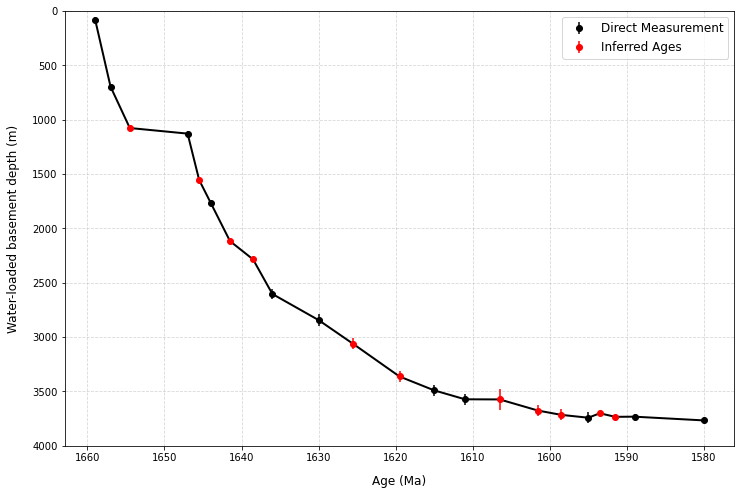

In [10]:
# Plot water-loaded subsidence for rifting beginning at 1659 Ma

fig = plt.figure(figsize=(12,8))

plt.plot(
    ages59,
    tec_sub59,
    color='black',
    linestyle='-',
    linewidth=2.0)

plt.errorbar(
    ages_dir59,
    sub_dir59,
    yerr=unc_dir59,
    fmt='o',
    color='k',
    label = "Direct Measurement")

plt.errorbar(
    ages_inf59,
    sub_inf59,
    yerr=unc_inf59,
    fmt='o',
    color='red',
    label="Inferred Ages")

plt.ylim(0, 4000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.ylabel('Water-loaded basement depth (m)', fontsize=12, labelpad = 12)
plt.xlabel('Age (Ma)', fontsize=12, labelpad = 12)
plt.grid(linestyle='--',alpha=0.5)

plt.legend(fontsize=12)

plt.show()

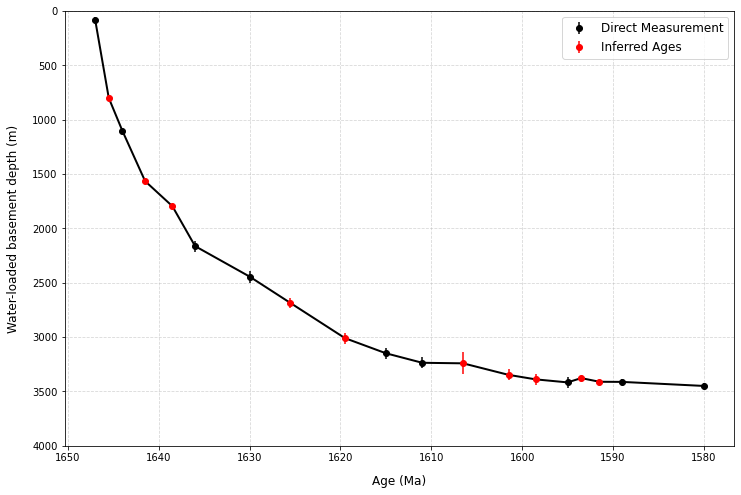

In [11]:
# Plot water-loaded subsidence for rifting beginning at 1647 Ma

fig = plt.figure(figsize=(12,8))

plt.plot(
    ages47,
    tec_sub47,
    color='black',
    linestyle='-',
    linewidth=2.0)

plt.errorbar(
    ages_dir47,
    sub_dir47,
    yerr=unc_dir47,
    fmt='o',
    color='k',
    label = "Direct Measurement")

plt.errorbar(
    ages_inf47,
    sub_inf47,
    yerr=unc_inf47,
    fmt='o',
    color='red',
    label="Inferred Ages")

# plt.plot(model_min[..., 1] + 1579, model_min[..., 3], 
#          color = 'C0', linestyle = "-", linewidth = 2, label = "Model subsidence")

plt.ylim(0, 4000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.ylabel('Water-loaded basement depth (m)', fontsize=12, labelpad = 12)
plt.xlabel('Age (Ma)', fontsize=12, labelpad = 12)
plt.grid(linestyle='--',alpha=0.5)

plt.legend(fontsize=12)

plt.show()

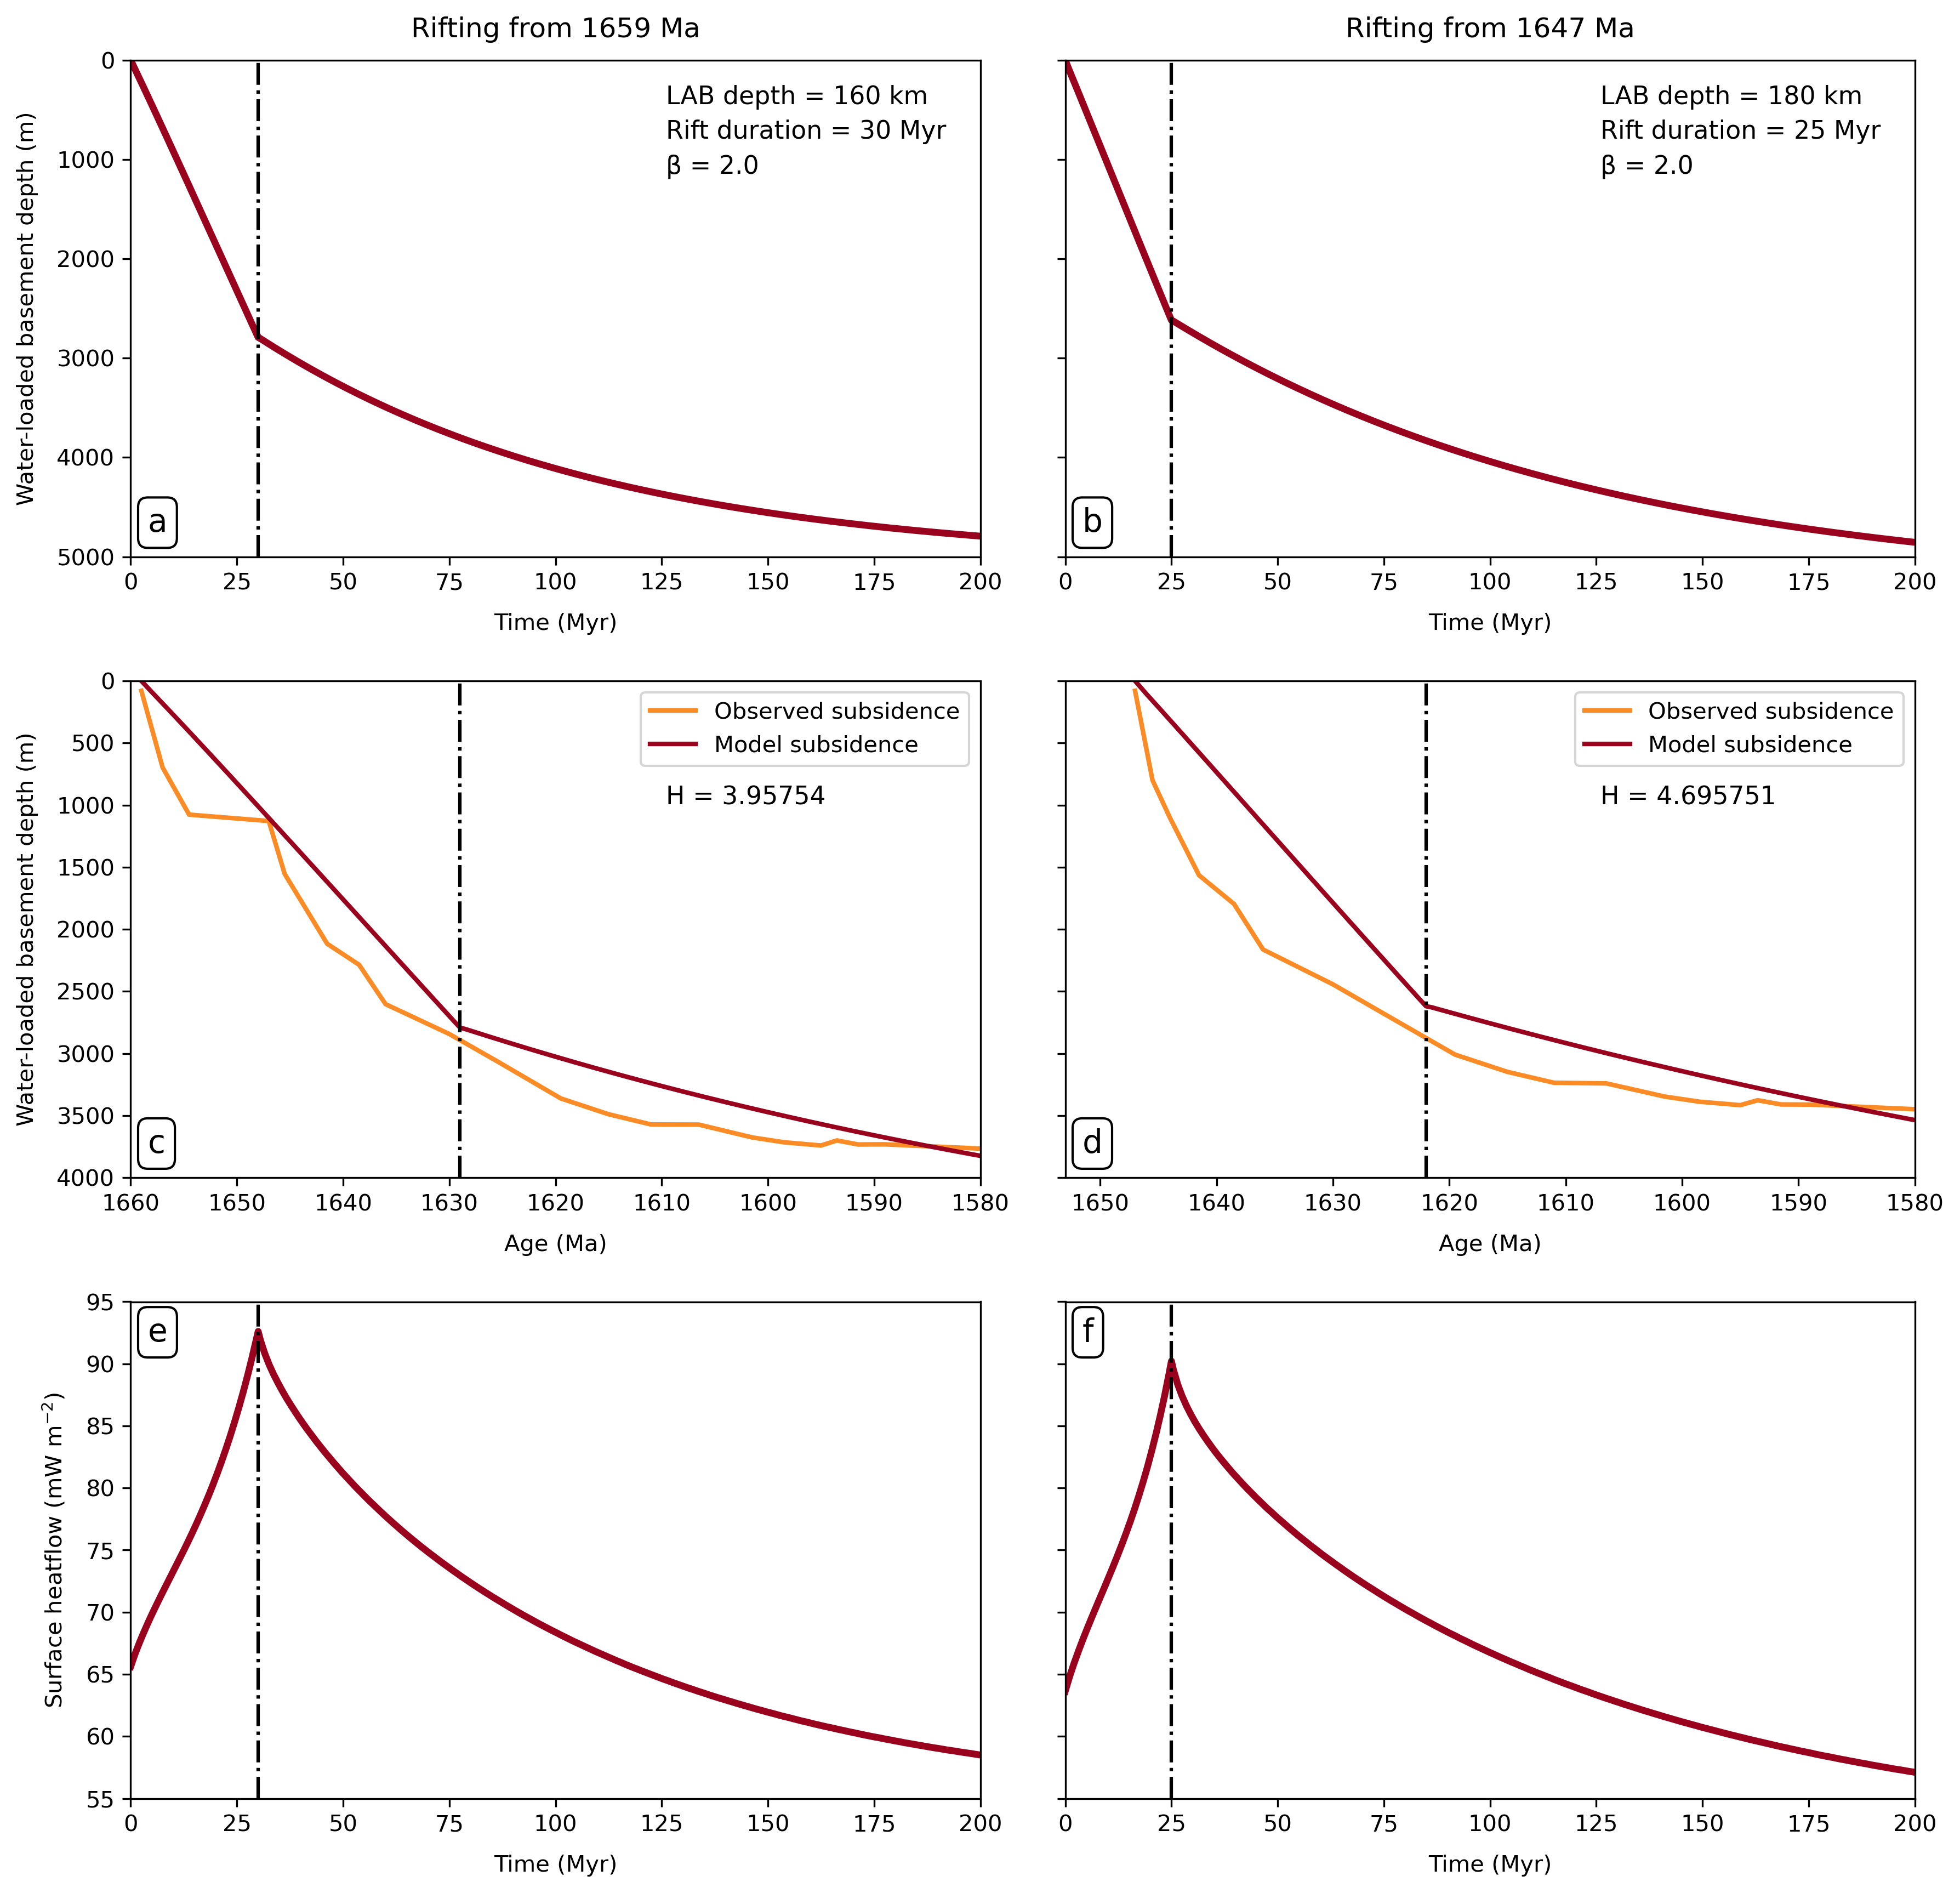

In [12]:
# Plot modelled vs observed subsidence, and surface heatflow

fig = plt.figure(figsize = [14, 14], dpi = 300)

my_purple = "#5F0F40"
my_red = "#9A031E"
my_yellow = "#FB8B24"
my_orange = "#E36414"
my_teal = "#0F4C5C"

ax1 = fig.add_subplot(321)
ax1.plot(model_min59[..., 1], model_min59[..., 3], color = my_red, linestyle = '-', linewidth = 3)
ax1.set_ylabel('Water-loaded basement depth (m)', fontsize=10, labelpad = 8)
ax1.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax1.axvline(x = rift_dur59, color = "black", linestyle = "-.") 
ax1.set_ylim(0, 5000)
ax1.set_xlim(0, 200)
plt.gca().invert_yaxis()
ax1.annotate(f"LAB depth = {z_LAB59} km", xy = (0.63, 0.95), 
             xycoords='axes fraction', ha='left', va='top', fontsize = 11)
ax1.annotate(f"\u03B2 = {beta59}", xy = (0.63, 0.81), xycoords='axes fraction', ha='left', va='top',
            fontsize = 11)
ax1.annotate(f"Rift duration = {rift_dur59} Myr", xy = (0.63, 0.88), 
             xycoords='axes fraction', ha='left', va='top', fontsize = 11)
ax1.annotate("a", xy=(0.02, 0.1), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
ax1.set_title('Rifting from 1659 Ma', pad = 10, fontsize = 12)


ax2 = fig.add_subplot(322, sharey = ax1)
ax2.plot(model_min47[..., 1], model_min47[..., 3], color = my_red, linestyle = '-', linewidth = 3)
ax2.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax2.axvline(x = rift_dur47, color = "black", linestyle = "-.") 
ax2.set_ylim(0, 5000)
ax2.set_xlim(0, 200)
plt.gca().invert_yaxis()
ax2.annotate(f"LAB depth = {z_LAB47} km", xy = (0.63, 0.95), 
             xycoords='axes fraction', ha='left', va='top', fontsize = 11)
ax2.annotate(f"\u03B2 = {beta47}", xy = (0.63, 0.81), xycoords='axes fraction', ha='left', va='top',
            fontsize = 11)
ax2.annotate(f"Rift duration = {rift_dur47} Myr", xy = (0.63, 0.88), 
             xycoords='axes fraction', ha='left', va='top', fontsize = 11)
ax2.annotate("b", xy=(0.02, 0.1), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.yticks(color = 'w')
ax2.set_title('Rifting from 1647 Ma', pad = 10, fontsize = 12)


ax3 = fig.add_subplot(323)
ax3.plot(np.flip(abs(time59 - time59[-1])) + 1, tec_sub59[::-1], 
         color = my_yellow, linestyle= '-', linewidth = 2, label = "Observed subsidence")
ax3.plot(model_min59[..., 1] + 1, model_min59[..., 3], 
         color = my_red, linestyle = "-", linewidth = 2, label = "Model subsidence")
# ax3.errorbar(abs(np.array(ages_dir59) - 1659) + 1, sub_dir59, yerr=unc_dir59, 
#              fmt='o', color = 'k', label = "Direct age")
# ax3.errorbar(abs(np.array(ages_inf59) - 1659) + 1, sub_inf59, yerr=unc_inf59, 
#              fmt='o', color = 'r', label = "Inferred age")
ax3.axvline(x = rift_dur59 + 1, color = "black", linestyle = "-.") 
ax3.set_ylim(0, 4000)
plt.gca().invert_yaxis()
ax3.set_xlim(0, 80)
ax3.legend()
ax3.annotate("c", xy=(0.02, 0.1), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
ax3.set_ylabel('Water-loaded basement depth (m)', fontsize=10, labelpad = 8)
ax3.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax3.annotate(f"H = {str(round(H_min59, 6))}", xy = (0.63, 0.79), 
            xycoords='axes fraction', ha='left', va='top', fontsize = 11)
new_tick_locations = np.arange(0, 81, 10)
def tick_function(X):
    V = X + 1580
    return V
ax3.set_xticks(new_tick_locations[::-1])
ax3.set_xticklabels(tick_function(new_tick_locations))
ax3.set_xlabel('Age (Ma)', fontsize = 10, labelpad = 8)


ax4 = fig.add_subplot(324, sharey = ax3)
ax4.plot(np.flip(abs(time47 - time47[-1])) + 3, tec_sub47[::-1], 
         color = my_yellow, linestyle= '-', linewidth = 2, label = "Observed subsidence")
ax4.plot(model_min47[..., 1] + 3, model_min47[..., 3], 
         color = my_red, linestyle = "-", linewidth = 2, label = "Model subsidence")
# ax4.errorbar(abs(np.array(ages_dir47) - 1647) + 3, sub_dir47, yerr=unc_dir47, 
#              fmt='o', color = 'k', label = "Direct age")
# ax4.errorbar(abs(np.array(ages_inf47) - 1647) + 3, sub_inf47, yerr=unc_inf47, 
#              fmt='o', color = 'r', label = "Inferred age")
ax4.axvline(x = rift_dur47 + 3, color = "black", linestyle = "-.") 
ax4.set_xlim(-3, 70)
ax4.legend()
ax4.annotate("d", xy=(0.02, 0.1), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
ax4.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax4.annotate(f"H = {str(round(H_min47, 6))}", xy = (0.63, 0.79), 
            xycoords='axes fraction', ha='left', va='top', fontsize = 11)
new_tick_locations = np.arange(0, 71, 10)
def tick_function(X):
    V = X + 1580
    return V
ax4.set_xticks(new_tick_locations[::-1])
ax4.set_xticklabels(tick_function(new_tick_locations))
ax4.set_xlabel('Age (Ma)', fontsize = 10, labelpad = 8)
plt.yticks(color = 'w')


ax5 = fig.add_subplot(325)
ax5.plot(model_min59[..., 1], model_min59[..., 2], color = my_red, linestyle= "-", linewidth = 3)
ax5.set_ylabel('Surface heatflow (mW m$^{-2}$)', fontsize=10, labelpad = 8)
ax5.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax5.axvline(x = rift_dur59, color = "black", linestyle = "-.")
ax5.set_ylim(55, 95)
ax5.set_xlim(0, 200)
ax5.annotate("e", xy=(0.02, 0.97), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))


ax6 = fig.add_subplot(326, sharey = ax5)
ax6.plot(model_min47[..., 1], model_min47[..., 2], color = my_red, linestyle= "-", linewidth = 3)
ax6.set_xlabel('Time (Myr)', fontsize=10, labelpad = 8)
ax6.axvline(x = rift_dur47, color = "black", linestyle = "-.")
ax6.set_xlim(0, 200)
ax6.annotate("f", xy=(0.02, 0.97), fontsize = 14, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.yticks(color = 'w')

plt.subplots_adjust(wspace=0.1, hspace=0.25)

C:\Users\edgar\AppData\Local\Temp\ipykernel_5936\1165859887.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


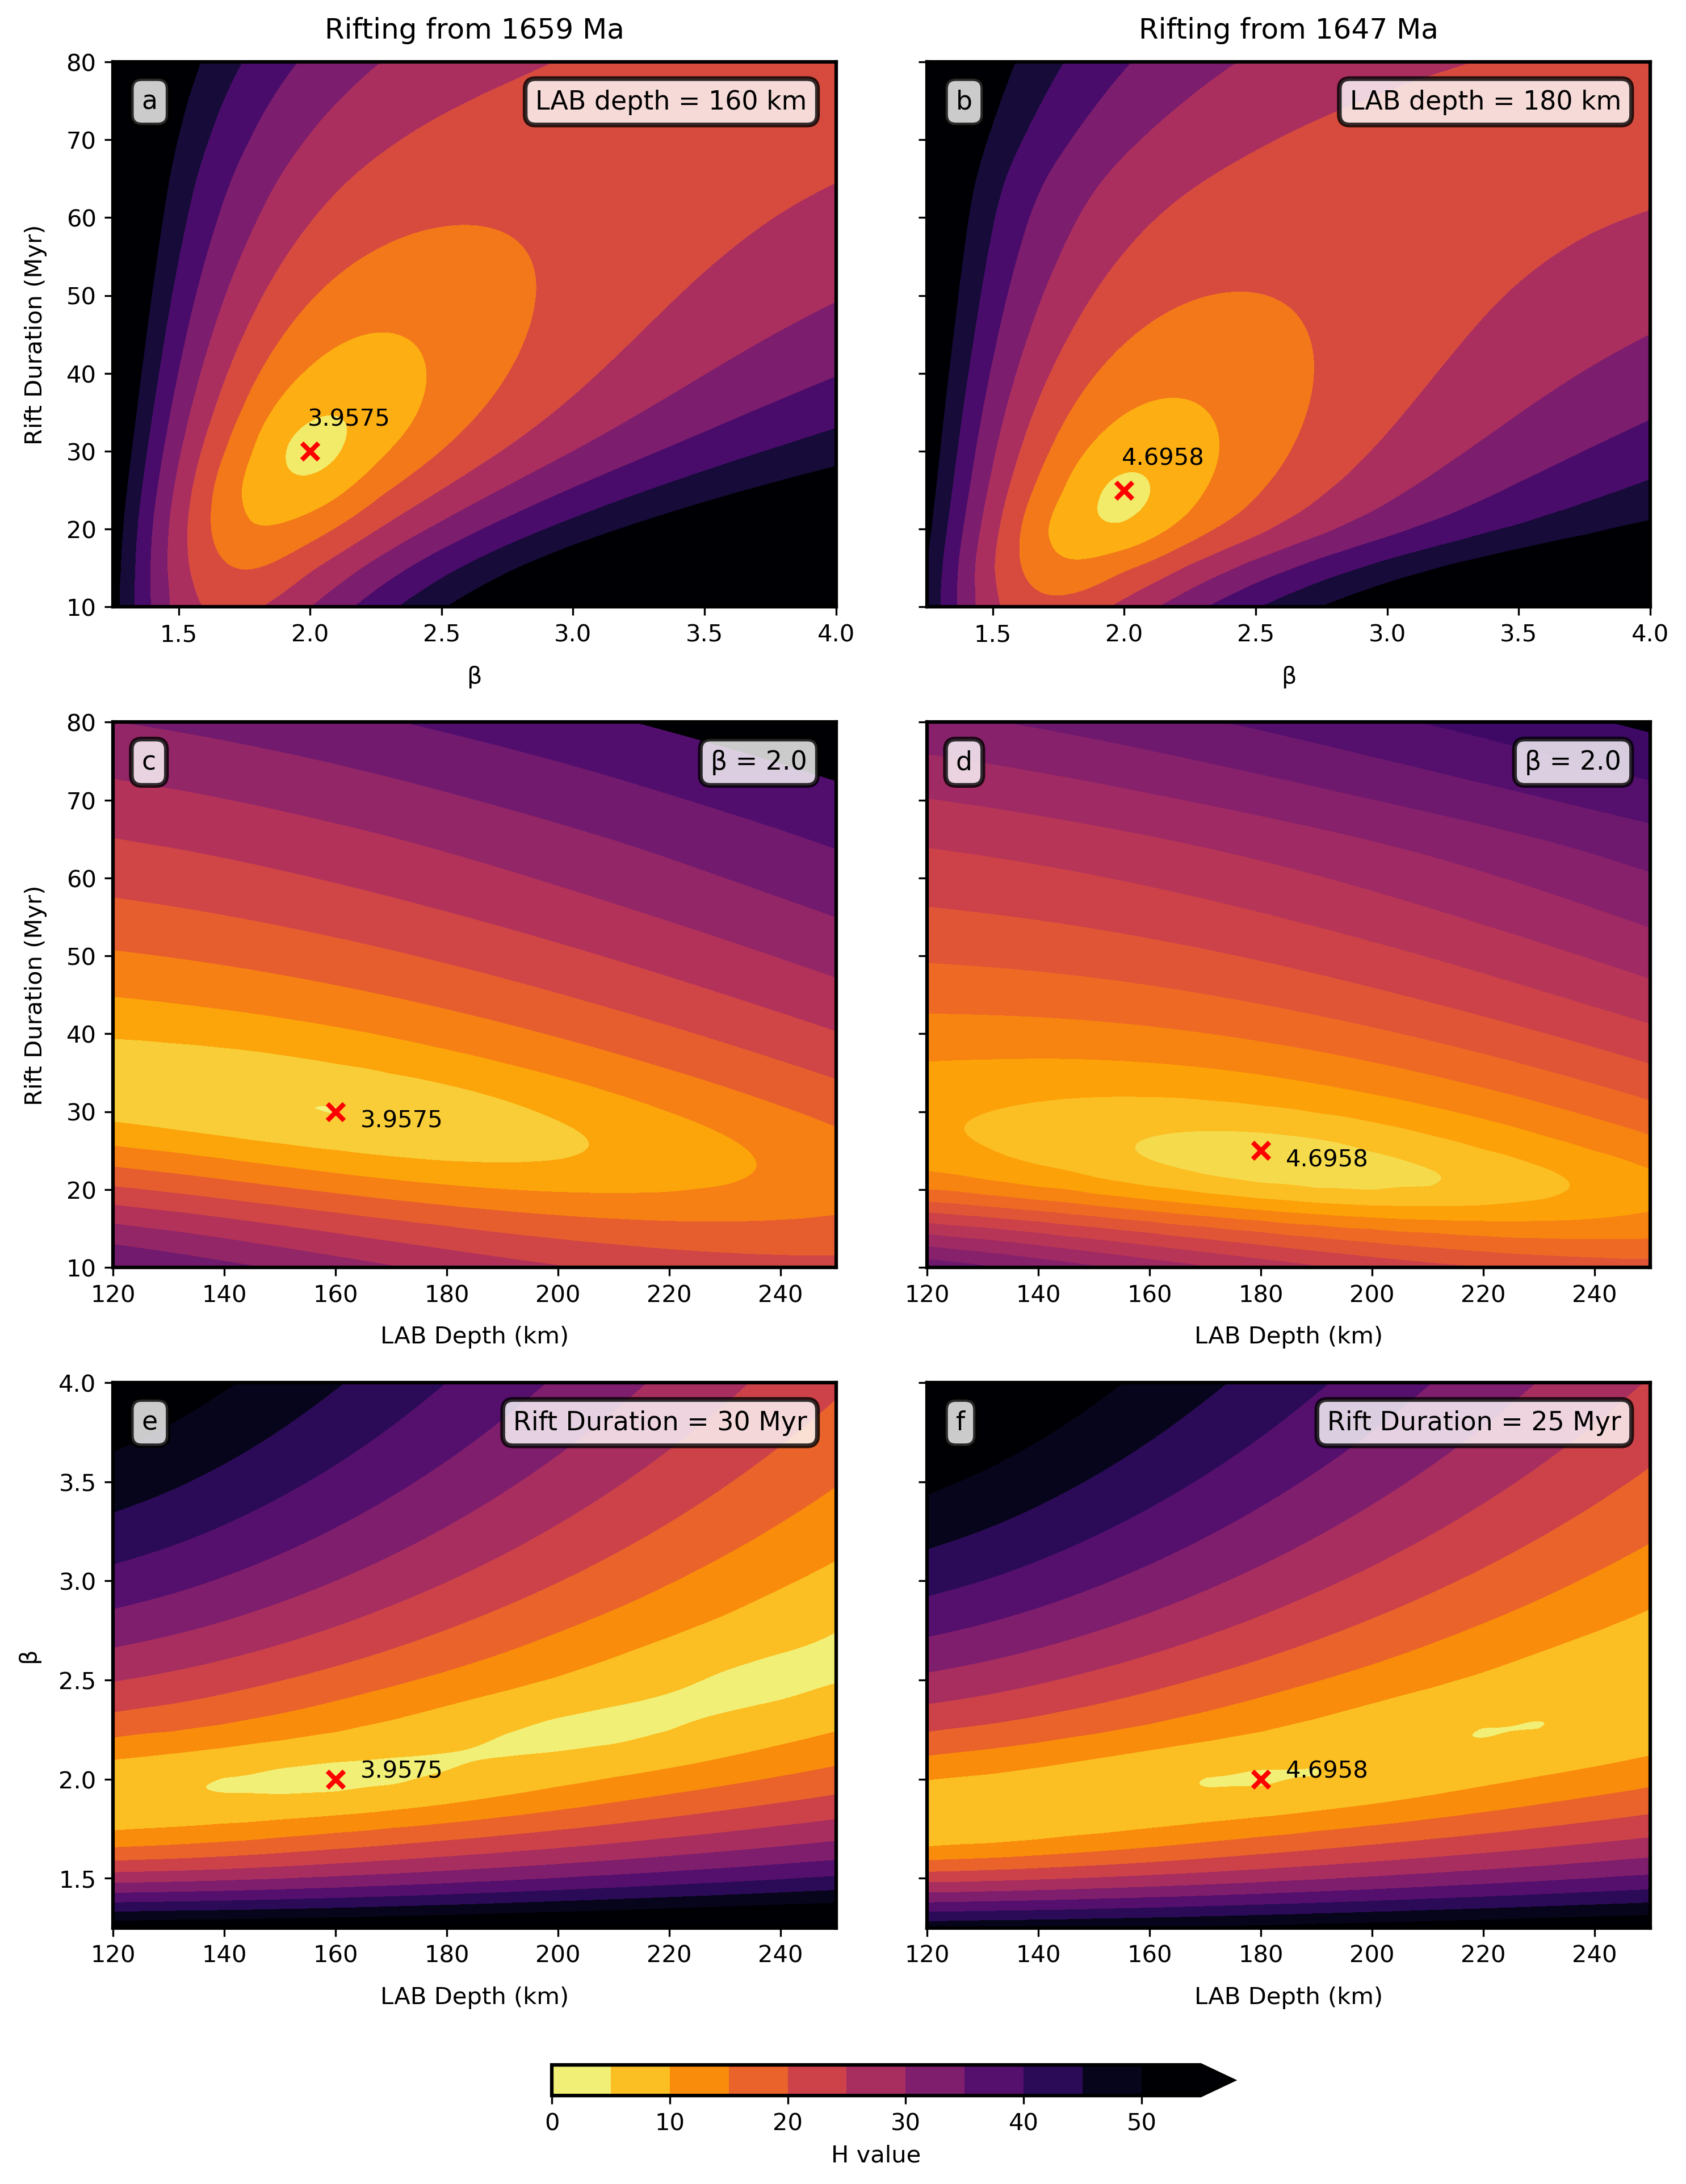

In [13]:
# Plot filled contours of height = H values for a fixed parameter

fig = plt.figure(figsize=(10,12), dpi = 300)
mpl.rcParams['axes.linewidth'] = 1.5

v_max = 50
v_min = 0
cmap = 'inferno_r'

def contour(data, ax):
    return ax.contourf(data['x'], data['y'], data, 
                       levels = 12, cmap = cmap, vmin = v_min, vmax = v_max,
                       extend = "max")
def scatter(x, y, ax):
    return ax.scatter(x, y, color = 'r', facecolors = 'r', 
                      s = 50, linewidth = 2, marker = 'x')

ax1 = fig.add_subplot(321)
contour(surfzlab59, ax1)
scatter(beta59, rift_dur59, ax1)
ax1.set_xlabel('\u03B2', fontsize = 10, labelpad = 8)
ax1.set_ylabel('Rift Duration (Myr)', fontsize = 10, labelpad = 8)
ax1.annotate(f"LAB depth = {z_LAB59} km", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax1.set_title('Rifting from 1659 Ma', pad = 10, fontsize = 12)
ax1.annotate("a", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax1.text(beta59 - 0.01, rift_dur59 + 3.3, round(H_min59, 4))

ax2 = fig.add_subplot(322, sharey = ax1)
contour(surfzlab47, ax2)
scatter(beta47, rift_dur47, ax2)
ax2.set_xlabel('\u03B2', fontsize = 10, labelpad = 8)
plt.yticks(color = 'w')
ax2.annotate(f"LAB depth = {z_LAB47} km", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax2.set_title('Rifting from 1647 Ma', pad = 10, fontsize = 12)
ax2.annotate("b", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax2.text(beta47 - 0.01, rift_dur47 + 3.3, round(H_min47, 4))

ax3 = fig.add_subplot(323)
contour(surfbeta59, ax3)
scatter(z_LAB59, rift_dur59, ax3)
ax3.set_xlabel('LAB Depth (km)', fontsize = 10, labelpad = 8)
ax3.set_ylabel('Rift Duration (Myr)', fontsize = 10, labelpad = 8)
ax3.annotate(f"\u03B2 = {beta59}", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax3.annotate("c", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax3.text(z_LAB59 + 4.5, rift_dur59 -2, round(H_min59, 4))


ax4 = fig.add_subplot(324, sharey = ax1)
contour(surfbeta47, ax4)
scatter(z_LAB47, rift_dur47, ax4)
ax4.set_xlabel('LAB Depth (km)', fontsize = 10, labelpad = 8)
plt.yticks(color = 'w')
ax4.annotate(f"\u03B2 = {beta47}", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax4.annotate("d", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax4.text(z_LAB47 + 4.5, rift_dur47 -2, round(H_min47, 4))

ax5 = fig.add_subplot(325)
contour(surfriftdur59, ax5)
scatter(z_LAB59, beta59, ax5)
ax5.set_xlabel('LAB Depth (km)', fontsize = 10, labelpad = 8)
ax5.set_ylabel('\u03B2', fontsize = 10, labelpad = 8)
ax5.annotate(f"Rift Duration = {rift_dur59} Myr", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax5.annotate("e", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax5.text(z_LAB59 + 4.5, beta59 + 0.01, round(H_min59, 4))

ax6 = fig.add_subplot(326, sharey = ax5)
sc = contour(surfriftdur47, ax6)
scatter(z_LAB47, beta47, ax6)
ax6.set_xlabel('LAB Depth (km)', fontsize = 10, labelpad = 8)
plt.yticks(color = 'w')
ax6.annotate(f"Rift Duration = {rift_dur47} Myr", xy = (0.96, 0.95), 
             xycoords='axes fraction', ha='right', va='top', fontsize = 11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=2, alpha = 0.8))
ax6.annotate("f", xy=(0.04, 0.95), fontsize = 11, xycoords='axes fraction', ha='left', va='top',
             bbox=dict(facecolor='none', edgecolor='black', fc = "white",
                       lw = 2, alpha = 0.8, boxstyle='round,pad=0.4'))
ax6.text(z_LAB47 + 4.5, beta47 + 0.01, round(H_min47, 4))


plt.colorbar(sc, cax = fig.add_axes([0.329, -0.03, 0.4, 0.015]), orientation = "horizontal", 
             label = "H value")

plt.subplots_adjust(wspace=0.05)
fig.tight_layout()